## Visualize GDD-based dynamic planting date

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import RdPu_8

from ideotype.utils import calc_gdd
from ideotype.wflow_setup import read_inityaml
from ideotype import DATA_PATH

In [2]:
# Read in relevant data
run_name = 'control_dympd'
yamlfile = None
dict_setup = read_inityaml(run_name, yamlfile=yamlfile)

df_stations = pd.read_csv(
    os.path.join(DATA_PATH, 'sites', 'stations_info_9110.csv'),
    dtype={'USAF': str})

df_siteyears = pd.read_csv(
    os.path.join(DATA_PATH, 'siteyears', 'siteyears_control_fixpd.csv'),
    dtype={'site': str})

In [3]:
# Estimate planting date (julian day)
jdays_start = []
jdays_plant = []

for row in np.arange(df_siteyears.shape[0]):
    site = df_siteyears.iloc[row]['site']
    year = df_siteyears.iloc[row]['year']

    fpath_weas = os.path.join(
        dict_setup['path_project'], *dict_setup['path_wea'])
    fpath_wea = os.path.join(fpath_weas, f'{site}_{year}.txt')

    df_wea = pd.read_csv(fpath_wea, sep='\t')
    temps = list(df_wea.temp)

    gdd = dict_setup['params']['gdd']
    loc = calc_gdd(temps, gdd_threshold=gdd)
    jday_plant = df_wea.loc[loc, 'jday']
    jday_start = jday_plant - 14  # start date 2 weeks prior to planting

    jdays_start.append(jday_start)
    jdays_plant.append(jday_plant)

df_siteyears['pdate'] = jdays_plant

In [4]:
# Merge dataset to include site lat/lon info
df_pdate = pd.merge(df_siteyears,
                    df_stations,
                    how='left',
                    left_on='site',
                    right_on='USAF')
df_pdate = df_pdate[['site', 'year', 'pdate', 'NSRDB_LAT (dd)', 'NSRDB_LON(dd)']]
df_pdate.columns = ['site', 'year', 'pdate', 'lat', 'lon']
df_pdate_mean = df_pdate.groupby('site').mean()

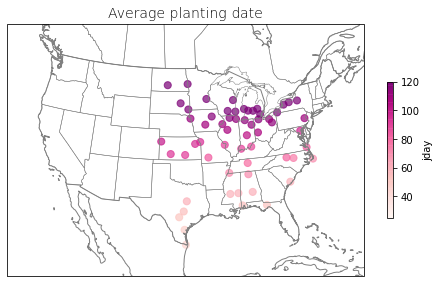

In [5]:
# Visualization
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123,-72,19,53])
mp = ax.scatter(df_pdate_mean.lon, df_pdate_mean.lat,
                transform=ccrs.PlateCarree(),
                c=df_pdate_mean.pdate, s=50,
                cmap=RdPu_8.mpl_colormap, alpha=0.7,
                vmin=25, vmax=120)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Average planting date', fontweight='light', fontsize=14)

fig.colorbar(mp, shrink=0.5, label='jday')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/dynamic_pdate.png', format='png', dpi=800)